In [ ]:
!pip install datasets transformers accelerate torch scikit-learn matplotlib


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.0/516.0 kB 33.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.


In [ ]:
# prompt: load the data from a folder each subfolder represent the class name. sub folder has image file with extension .jpg and .JPG lowecase and uppercase

import os
import cv2
import pathlib
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import pandas as pd
import threading

# ... (rest of your imports and code)

# Add these imports if you haven't already
from datasets import load_dataset

# Use the 'imagefolder' builder to load the dataset
# The builder automatically infers classes from subfolder names
dataset = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/Files to Transfer/corn dataset/data")

dataset

Resolving data files:   0%|          | 0/4188 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4188
    })
})

In [ ]:
dataset['train'].features

{'image': Image(mode=None, decode=True),
 'label': ClassLabel(names=['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy'])}

In [ ]:
# Split the training data into train and test (let's say 10% for the test set)
train_test_split = dataset['train'].train_test_split(test_size=0.1)

# Further split the training set to get a validation set (e.g., 10% of the training set)
train_val_split = train_test_split['train'].train_test_split(test_size=0.1)

# Combine the splits into a new DatasetDict
final_dataset = {
    'train': train_val_split['train'],
    'val': train_val_split['test'],
    'test': train_test_split['test']
}

final_dataset

{'train': Dataset({
     features: ['image', 'label'],
     num_rows: 3392
 }),
 'val': Dataset({
     features: ['image', 'label'],
     num_rows: 377
 }),
 'test': Dataset({
     features: ['image', 'label'],
     num_rows: 419
 })}

In [ ]:
train_ds = final_dataset["train"]
val_ds = final_dataset["val"]
test_ds = final_dataset["test"]

In [ ]:
id2label = {id: label for id, label in enumerate(train_ds.features["label"].names)}
label2id = {label: id for id, label in id2label.items()}
id2label, id2label[train_ds[0]["label"]]

({0: 'Blight', 1: 'Common_Rust', 2: 'Gray_Leaf_Spot', 3: 'Healthy'}, 'Blight')

In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor, SwinForImageClassification, AutoImageProcessor
import torch

# Define the number of labels based on your dataset
num_labels = len(id2label)

# Load ViT model and processor
vit_model_name = "google/vit-base-patch16-224-in21k"
vit_processor = ViTImageProcessor.from_pretrained(vit_model_name)
vit_model = ViTForImageClassification.from_pretrained(vit_model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)

# Load Swin model and processor for image classification
swin_model_name = "microsoft/swin-base-patch4-window7-224"
# Use AutoImageProcessor as a more general way to load processors
swin_processor = AutoImageProcessor.from_pretrained(swin_model_name)
swin_model = SwinForImageClassification.from_pretrained(swin_model_name, num_labels=num_labels, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

print("ViT model and processor loaded.")
print("Swin model and processor loaded.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

ViTForImageClassification LOAD REPORT from: google/vit-base-patch16-224-in21k
Key                 | Status     | 
--------------------+------------+-
pooler.dense.weight | UNEXPECTED | 
pooler.dense.bias   | UNEXPECTED | 
classifier.bias     | MISSING    | 
classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing form the checkpoint. Consider training on your downstream task.


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/449 [00:00<?, ?it/s]

SwinForImageClassification LOAD REPORT from: microsoft/swin-base-patch4-window7-224
Key               | Status   |                                                                                          
------------------+----------+------------------------------------------------------------------------------------------
classifier.bias   | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000]) vs model:torch.Size([4])            
classifier.weight | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000, 1024]) vs model:torch.Size([4, 1024])

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight.


ViT model and processor loaded.
Swin model and processor loaded.


In [ ]:
import torch.nn as nn
import torch

class HybridImageClassifier(nn.Module):
    def __init__(self, vit_model, swin_model, num_labels):
        super(HybridImageClassifier, self).__init__()
        self.vit = vit_model
        self.swin = swin_model

        # Remove the classification heads from the pre-trained models
        self.vit.classifier = nn.Identity()
        self.swin.classifier = nn.Identity()

        # Define a new classification layer
        # The input size is the sum of the output sizes of the two models' hidden states
        vit_output_size = vit_model.config.hidden_size
        swin_output_size = swin_model.config.hidden_size
        self.classifier = nn.Linear(vit_output_size + swin_output_size, num_labels)

    def forward(self, pixel_values):
        # Pass input through both models
        vit_outputs = self.vit(pixel_values, output_hidden_states=True)
        swin_outputs = self.swin(pixel_values, output_hidden_states=True)

        # Get the hidden states before the classification head
        # For ViT, it's the last hidden state of the [CLS] token
        # For Swin, it's the pooled output (or last hidden state)
        vit_hidden_state = vit_outputs.hidden_states[-1][:, 0, :]
        # Access the last hidden state for Swin
        swin_hidden_state = swin_outputs.hidden_states[-1]
        # Swin's last hidden state needs to be pooled or averaged. Let's average over spatial dimensions.
        # The shape of swin_outputs.hidden_states[-1] is (batch_size, sequence_length, hidden_size)
        # We want to average over the sequence_length dimension to get (batch_size, hidden_size)
        swin_hidden_state = torch.mean(swin_hidden_state, dim=1)


        # Concatenate the hidden states
        combined_features = torch.cat((vit_hidden_state, swin_hidden_state), dim=1)

        # Pass through the new classification layer
        logits = self.classifier(combined_features)

        return logits

# Instantiate the hybrid model
hybrid_model = HybridImageClassifier(vit_model, swin_model, num_labels)
print(hybrid_model)
print("Hybrid image classifier model defined and instantiated.")

HybridImageClassifier(
  (vit): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (intermediate): ViTIntermediate(
              (dense

In [ ]:
from torch.utils.data import DataLoader
from transformers import ViTImageProcessor, AutoImageProcessor
import torch
from PIL import Image

vit_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

def preprocess_image(examples):
    processed_inputs = {"labels": examples["label"]}
    processed_pixel_values = []

    for image in examples["image"]:
        # Check image type and convert if necessary
        if not isinstance(image, Image.Image):
             # Attempt to open the image if it's a file path or similar
             try:
                 image = Image.open(image)
             except Exception as e:
                 print(f"Could not open image: {e}")
                 continue # Skip this image if it cannot be opened

        print(f"Image size before processing: {image.size}")
        # Use the ViT processor to preprocess the image
        # Ensure images are resized to the processor's expected size
        processed_image = vit_processor(images=image, return_tensors="pt", do_convert_rgb=True, size=(224, 224))
        print(f"Processed image shape: {processed_image['pixel_values'].shape}")
        processed_pixel_values.append(processed_image['pixel_values'].squeeze()) # Squeeze to remove batch dimension

    processed_inputs["pixel_values"] = torch.stack(processed_pixel_values)
    return processed_inputs


# Apply the preprocessing function to the datasets
processed_train_ds = train_ds.map(preprocess_image, batched=True)
processed_val_ds = val_ds.map(preprocess_image, batched=True)
processed_test_ds = test_ds.map(preprocess_image, batched=True)

# Set the format of the processed datasets to PyTorch tensors
processed_train_ds.set_format("torch")
processed_val_ds.set_format("torch")
processed_test_ds.set_format("torch")

# Define a custom collate function to handle the batching
def custom_collate_fn(batch):
    # Extract pixel values and labels from the batch
    pixel_values = torch.stack([item["pixel_values"] for item in batch]) # Removed .squeeze() here
    labels = torch.tensor([item["labels"] for item in batch])

    return {"pixel_values": pixel_values, "labels": labels}


# Create DataLoaders for the processed datasets
batch_size = 32
train_dataloader = DataLoader(processed_train_ds, shuffle=True, batch_size=batch_size, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(processed_val_ds, shuffle=False, batch_size=batch_size, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(processed_test_ds, shuffle=False, batch_size=batch_size, collate_fn=custom_collate_fn)

print("Data preprocessing complete and DataLoaders created with custom collate function.")

Map:   0%|          | 0/3392 [00:00<?, ? examples/s]

Streaming output truncated to the last 5000 lines.
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (1200, 630)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (1158, 1200)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size befor

Map:   0%|          | 0/377 [00:00<?, ? examples/s]

Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.

Map:   0%|          | 0/419 [00:00<?, ? examples/s]

Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.Size([1, 3, 224, 224])
Image size before processing: (256, 256)
Processed image shape: torch.

In [ ]:
from tqdm.auto import tqdm
import torch

# Define the optimizer and loss function
optimizer = torch.optim.AdamW(hybrid_model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hybrid_model.to(device)

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies_epoch = [] # Initialize list to store training accuracy
val_accuracies = []

# Training loop
epochs = 15 # You can adjust the number of epochs
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    hybrid_model.train()
    total_loss = 0
    correct_train_predictions = 0 # Track correct training predictions
    total_train_samples = 0 # Track total training samples

    for batch in tqdm(train_dataloader):
        # Move batch to device
        inputs = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = hybrid_model(inputs)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)


    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_train_predictions / total_train_samples # Calculate average training accuracy
    train_losses.append(avg_train_loss) # Store training loss
    train_accuracies_epoch.append(train_accuracy) # Store training accuracy
    print(f"Average training loss: {avg_train_loss}")
    print(f"Training accuracy: {train_accuracy}")


    # Validation loop
    hybrid_model.eval()
    total_val_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            # Move batch to device
            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = hybrid_model(inputs)
            loss = loss_fn(outputs, labels)

            total_val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    accuracy = correct_predictions / len(val_ds)
    val_losses.append(avg_val_loss) # Store validation loss
    val_accuracies.append(accuracy) # Store validation accuracy
    print(f"Average validation loss: {avg_val_loss}")
    print(f"Validation accuracy: {accuracy}")

print("Training complete.")

Epoch 1/15


  0%|          | 0/106 [00:00<?, ?it/s]

Average training loss: 0.2483837016910877
Training accuracy: 0.9159787735849056


  0%|          | 0/12 [00:00<?, ?it/s]

Average validation loss: 0.10798261182693143
Validation accuracy: 0.9655172413793104
Epoch 2/15


  0%|          | 0/106 [00:00<?, ?it/s]

Average training loss: 0.05257681609715669
Training accuracy: 0.9817216981132075


  0%|          | 0/12 [00:00<?, ?it/s]

Average validation loss: 0.0635740711974601
Validation accuracy: 0.9655172413793104
Epoch 3/15


  0%|          | 0/106 [00:00<?, ?it/s]

Average training loss: 0.017336708541202
Training accuracy: 0.995872641509434


  0%|          | 0/12 [00:00<?, ?it/s]

Average validation loss: 0.07165065820784851
Validation accuracy: 0.9681697612732095
Epoch 4/15


  0%|          | 0/106 [00:00<?, ?it/s]

Average training loss: 0.0333214184619516
Training accuracy: 0.9914504716981132


  0%|          | 0/12 [00:00<?, ?it/s]

Average validation loss: 0.1057452067034319
Validation accuracy: 0.9681697612732095
Epoch 5/15


  0%|          | 0/106 [00:00<?, ?it/s]

Average training loss: 0.015808820732724237
Training accuracy: 0.995872641509434


  0%|          | 0/12 [00:00<?, ?it/s]

Average validation loss: 0.10945929711063702
Validation accuracy: 0.9761273209549072
Epoch 6/15


  0%|          | 0/106 [00:00<?, ?it/s]

Average training loss: 0.009559727377014703
Training accuracy: 0.9964622641509434


  0%|          | 0/12 [00:00<?, ?it/s]

Average validation loss: 0.21414527669548988
Validation accuracy: 0.9416445623342176
Epoch 7/15


  0%|          | 0/106 [00:00<?, ?it/s]

Average training loss: 0.07897214355453232
Training accuracy: 0.9784787735849056


  0%|          | 0/12 [00:00<?, ?it/s]

Average validation loss: 0.101132139932209
Validation accuracy: 0.9655172413793104
Epoch 8/15


  0%|          | 0/106 [00:00<?, ?it/s]

Average training loss: 0.0310101259645582
Training accuracy: 0.9887971698113207


  0%|          | 0/12 [00:00<?, ?it/s]

Average validation loss: 0.09316987224277302
Validation accuracy: 0.9761273209549072
Epoch 9/15


  0%|          | 0/106 [00:00<?, ?it/s]

Average training loss: 0.020075584630728182
Training accuracy: 0.9949882075471698


  0%|          | 0/12 [00:00<?, ?it/s]

Average validation loss: 0.07907616261218209
Validation accuracy: 0.9814323607427056
Epoch 10/15


  0%|          | 0/106 [00:00<?, ?it/s]

Average training loss: 0.006958691843636807
Training accuracy: 0.9985259433962265


  0%|          | 0/12 [00:00<?, ?it/s]

Average validation loss: 0.0769849523051865
Validation accuracy: 0.9734748010610079
Epoch 11/15


  0%|          | 0/106 [00:00<?, ?it/s]

Average training loss: 0.004017528416058993
Training accuracy: 0.9988207547169812


  0%|          | 0/12 [00:00<?, ?it/s]

Average validation loss: 0.07385849737511307
Validation accuracy: 0.9761273209549072
Epoch 12/15


  0%|          | 0/106 [00:00<?, ?it/s]

Average training loss: 0.0028613951794710067
Training accuracy: 0.9988207547169812


  0%|          | 0/12 [00:00<?, ?it/s]

Average validation loss: 0.0663116382154385
Validation accuracy: 0.9840848806366048
Epoch 13/15


  0%|          | 0/106 [00:00<?, ?it/s]

Average training loss: 0.0024224302383353854
Training accuracy: 0.9985259433962265


  0%|          | 0/12 [00:00<?, ?it/s]

Average validation loss: 0.06924154366121608
Validation accuracy: 0.9893899204244032
Epoch 14/15


  0%|          | 0/106 [00:00<?, ?it/s]

Average training loss: 0.002252271153361965
Training accuracy: 0.9991155660377359


  0%|          | 0/12 [00:00<?, ?it/s]

Average validation loss: 0.0767319391828399
Validation accuracy: 0.9708222811671088
Epoch 15/15


  0%|          | 0/106 [00:00<?, ?it/s]

Average training loss: 0.003228060679123889
Training accuracy: 0.9985259433962265


  0%|          | 0/12 [00:00<?, ?it/s]

Average validation loss: 0.06934439319449363
Validation accuracy: 0.9787798408488063
Training complete.


In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score
import numpy as np
import torch

# Evaluate the model on the test set
hybrid_model.eval()
test_loss = 0
correct_predictions_test = 0
all_labels = []
all_predictions = []
all_probs = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = hybrid_model(inputs)
        loss = loss_fn(outputs, labels)

        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions_test += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        # Get probabilities for AUC calculation (assuming multi-class, using softmax)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())


avg_test_loss = test_loss / len(test_dataloader)
test_accuracy = correct_predictions_test / len(test_ds)

print("Evaluation Results:")
print(f"Average Test Loss: {avg_test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

# AUC Score (for multi-class, AUC is typically calculated per class or using one-vs-rest)
# Using one-vs-rest approach for simplicity
# Need to convert labels to one-hot encoding for roc_auc_score
from sklearn.preprocessing import label_binarize
num_classes = len(id2label)
all_labels_binarized = label_binarize(all_labels, classes=range(num_classes))

# Ensure all_probs has the correct shape (num_samples, num_classes)
all_probs = np.array(all_probs)
if all_probs.shape[1] != num_classes:
    print(f"Warning: Shape mismatch for all_probs ({all_probs.shape}) and num_classes ({num_classes}). Cannot calculate AUC.")
else:
    auc_score = roc_auc_score(all_labels_binarized, all_probs, multi_class='ovr')
    print(f"\nAUC Score (One-vs-Rest): {auc_score}")

# Print training and validation metrics (already printed during training, but can re-print here for summary)
print("\nSummary of Training and Validation Metrics:")
# Assuming avg_train_loss, avg_val_loss, and accuracy are available from the last epoch of training
# If not, you would need to store these during training
if 'avg_train_loss' in locals() and 'avg_val_loss' in locals() and 'accuracy' in locals():
     print(f"Last Epoch Average Training Loss: {avg_train_loss}")
     print(f"Last Epoch Average Validation Loss: {avg_val_loss}")
     print(f"Last Epoch Validation Accuracy: {accuracy}")
else:
    print("Training and validation metrics from last epoch are not available in current scope.")

Evaluation Results:
Average Test Loss: 0.03877296744957245
Test Accuracy: 0.9880668257756563

Confusion Matrix:
[[112   0   2   0]
 [  2 135   0   0]
 [  1   0  50   0]
 [  0   0   0 117]]

AUC Score (One-vs-Rest): 0.9995826729180914

Summary of Training and Validation Metrics:
Last Epoch Average Training Loss: 0.003228060679123889
Last Epoch Average Validation Loss: 0.06934439319449363
Last Epoch Validation Accuracy: 0.9787798408488063


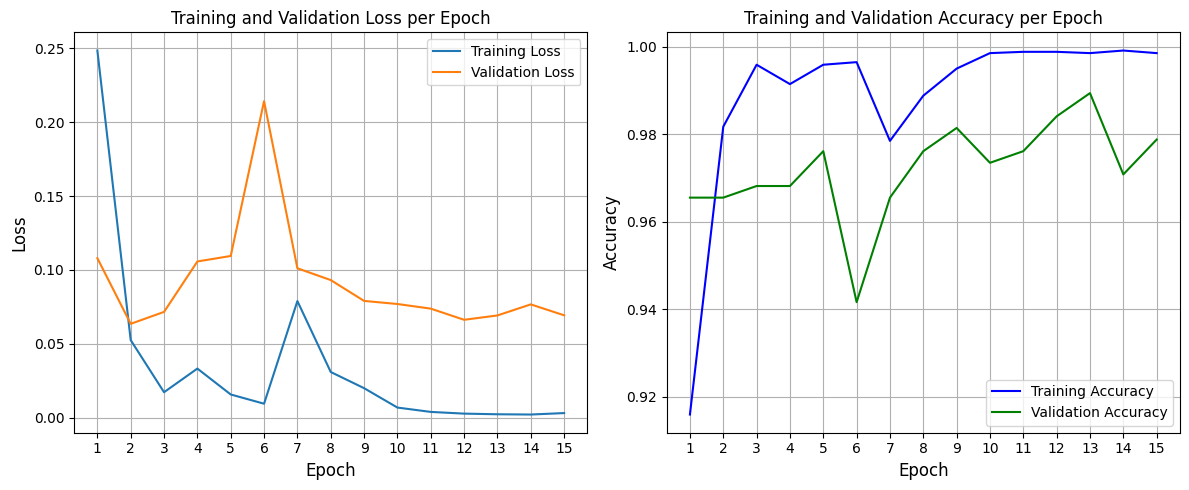

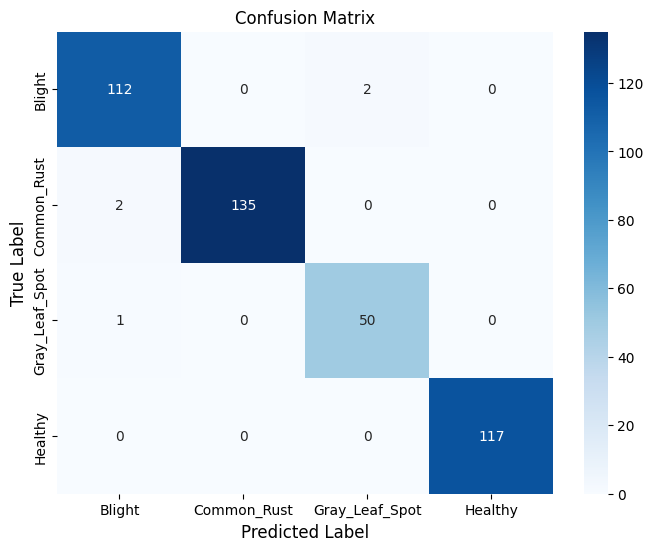

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming train_losses, val_losses, train_accuracies_epoch, and val_accuracies are available
# Assuming conf_matrix and id2label are available from evaluation

# Create a range of epoch numbers for the x-axis
epochs_range = range(1, len(train_losses) + 1)

# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(epochs_range) # Ensure ticks are at each epoch

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies_epoch, label='Training Accuracy', color='blue') # Plotting training accuracy
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(epochs_range) # Ensure ticks are at each epoch


plt.tight_layout()
plt.show()

# Plotting Confusion Matrix (assuming conf_matrix is available from evaluation)
# Assuming the class labels are available in id2label
class_labels = list(id2label.values())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Assuming all_labels and all_predictions are available from the evaluation cell
# Assuming id2label is also available

# Get the class names
target_names = list(id2label.values())

# Generate and print the classification report with 4 decimal places
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=target_names, digits=4))


Classification Report:
                precision    recall  f1-score   support

        Blight     0.9739    0.9825    0.9782       114
   Common_Rust     1.0000    0.9854    0.9926       137
Gray_Leaf_Spot     0.9615    0.9804    0.9709        51
       Healthy     1.0000    1.0000    1.0000       117

      accuracy                         0.9881       419
     macro avg     0.9839    0.9871    0.9854       419
  weighted avg     0.9882    0.9881    0.9881       419



/tmp/ipython-input-714462779.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes) # Get a colormap


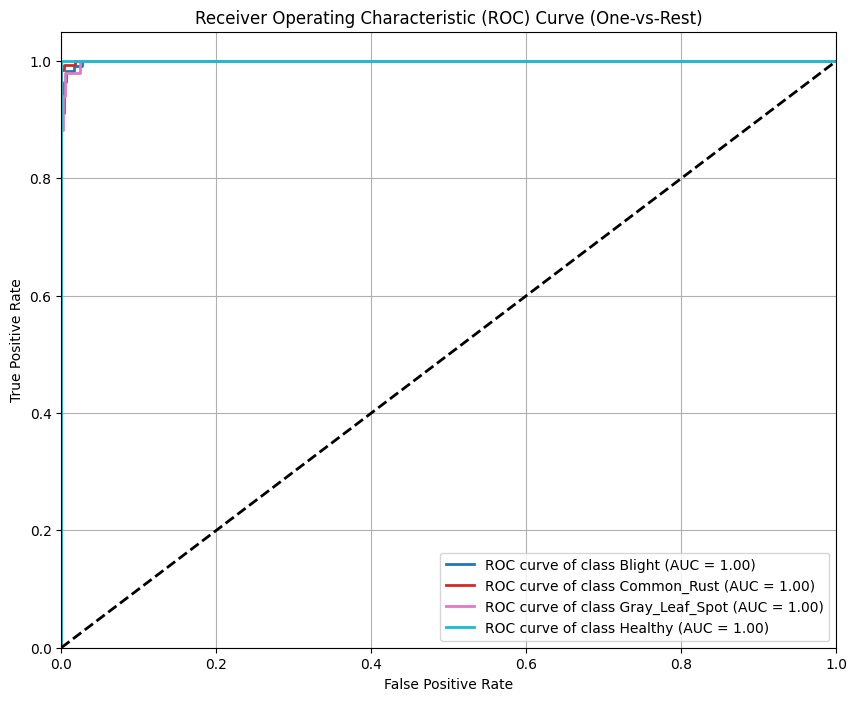

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

# Assuming all_labels and all_probs are available from the evaluation cell
# Assuming id2label is also available

# Binarize the true labels for multi-class ROC curve
num_classes = len(id2label)
all_labels_binarized = label_binarize(all_labels, classes=range(num_classes))

# Check if all_probs has the correct shape before calculating ROC curves
if all_probs.shape[1] != num_classes:
    print(f"Warning: Shape mismatch for all_probs ({all_probs.shape}) and num_classes ({num_classes}). Cannot calculate ROC curves.")
else:
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curves
    plt.figure(figsize=(10, 8))
    colors = plt.cm.get_cmap('tab10', num_classes) # Get a colormap

    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                 label='ROC curve of class {0} (AUC = {1:0.2f})'.format(id2label[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Plot the diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()